# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

display(geo_data_0.head(5))
display(geo_data_1.head(5))
display(geo_data_2.head(5))

display(geo_data_0.describe())
display(geo_data_1.describe())
display(geo_data_2.describe())

geo_data_0.info()
geo_data_1.info()
geo_data_2.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8

In [3]:
print("Найдено дубликатов в данных региона 0:", geo_data_0.duplicated().sum())
print("Найдено дубликатов в данных региона 1:", geo_data_1.duplicated().sum())
print("Найдено дубликатов в данных региона 2:", geo_data_2.duplicated().sum())

Найдено дубликатов в данных региона 0: 0
Найдено дубликатов в данных региона 1: 0
Найдено дубликатов в данных региона 2: 0


## Обучение и проверка модели

Обучим и проверим модель для каждого региона:

2.1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.

2.2. Обучите модель и сделайте предсказания на валидационной выборке.

2.3. Сохраните предсказания и правильные ответы на валидационной выборке.

2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.

2.5. Проанализируйте результаты.

In [4]:
def train_model(geo_data):
    ###
    #2.1 Выделим 75% данных для обучаюшей выборки, и 25% данных для проверки
    features = geo_data.drop(['id','product'], axis=1) 
    target = geo_data['product']                               # Целевой признак
    
    #print(features, target)
    # Разобъем данные на обучающую и валидационную выборки в соотношении 75:25
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)

    pd.options.mode.chained_assignment = None # (!) игнорировать предупреждение
    
    #display(features_train)
    # Создадим объект StandardScaler (мат. ожидание = 0, дисперси = 1) и настроим его на обучающих данных
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric]) 

    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])

    #display(features_train.head(10))
    #2.2 Обучим модель на валидационной выборке
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    #2.4 Напечатаем на экране средний запа предсказанного сырья
    print('Средний запас предсказанного сырья равна ', predictions_valid.mean())

    rms = sqrt(mean_squared_error(target_valid, predictions_valid))
    #2.4 Напечатаем на экране RMSE модели
    print("RMSE модели на валидационной выборке:", rms)
    #2.3 Сохраним предсказания и правильные ответы на валидационной выборке
    predictions_valid = pd.Series(predictions_valid)
    target_valid = pd.Series(target_valid.reset_index(drop=True))
    return predictions_valid, target_valid

print("Модель для региона 0:")
predictions_0, target_0 = train_model(geo_data_0)
print()
print("Модель для региона 1:")
predictions_1, target_1 = train_model(geo_data_1)
print()
print("Модель для региона 2:")
predictions_2, target_2 = train_model(geo_data_2)
print()

Модель для региона 0:
Средний запас предсказанного сырья равна  92.59256778438038
RMSE модели на валидационной выборке: 37.5794217150813

Модель для региона 1:
Средний запас предсказанного сырья равна  68.728546895446
RMSE модели на валидационной выборке: 0.8930992867756158

Модель для региона 2:
Средний запас предсказанного сырья равна  94.96504596800489
RMSE модели на валидационной выборке: 40.02970873393434



---------------
    Регион 0    
---------------


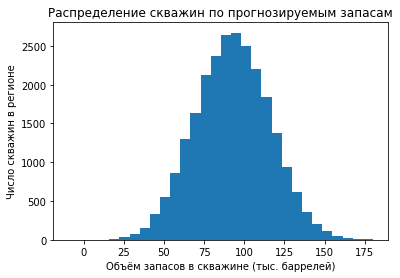

---------------
    Регион 1    
---------------


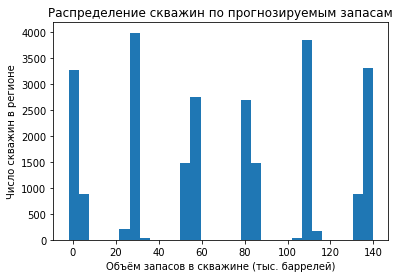

---------------
    Регион 2    
---------------


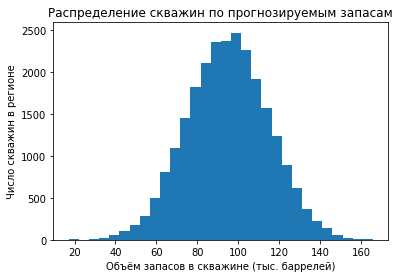

In [5]:
def predictions_hist(predictions):
    plt.hist(predictions, bins=30)
    plt.title("Распределение скважин по прогнозируемым запасам")
    plt.xlabel("Объём запасов в скважине (тыс. баррелей)")
    plt.ylabel("Число скважин в регионе")
    plt.show()

print('---------------')
print('    Регион 0    ')
print('---------------')
predictions_hist(predictions_0)
print('---------------')
print('    Регион 1    ')
print('---------------')
predictions_hist(predictions_1)
print('---------------')
print('    Регион 2    ')
print('---------------')
predictions_hist(predictions_2)

<div class="alert alert-info">
<b>Вывод: </b> 

Средний запас сырья во втором регионе меньше, чем в первом и третьем (69 тыс. баррелей vs >90 тыс. баррелей в первом и в третьем регионах), но модель на данных второго региона работает точнее (метрика качества RMSE минимальная:RMSE=0.893).
    
Регион 0 и регион 2 имеют нормальное распределение объемов запасов в скважине.
</div>

## Подготовка к расчёту прибыли

Подготовимся к расчету прибыли:

3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.

3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.

3.3. Напишите выводы по этапу подготовки расчёта прибыли.

In [6]:
#3.1 Ключевые значения переменных
#---При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
#---Бюджет на разработку скважин в регионе — 10 млрд рублей.
#---При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, 
#---поскольку объём указан в тысячах баррелей.
#---После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. 
#---Среди них выбирают регион с наибольшей средней прибылью.
RESEARCH_POINTS = 500
BEST_POINTS = 200
BUDGET_FOR_DEVELOPMENT = 10**10
PRICE_BARREL = 450
REVENUE_PRODUCT = 450000 
PROBABILITY_OF_LOSSES = 0.025

In [7]:
#3.2 Расчет достаточного объема сырья для безубыточной разработки новой скважины
break_even_point = BUDGET_FOR_DEVELOPMENT/ (REVENUE_PRODUCT * BEST_POINTS) #в тыс баррелей

print("Достаточный объём сырья для безубыточной разработки новой скважины в тыс. баррелей:", round(break_even_point,1))

Достаточный объём сырья для безубыточной разработки новой скважины в тыс. баррелей: 111.1


<div class="alert alert-info">
<b>Вывод: </b> 
Достаточный объём сырья для безубыточной разработки новой скважины 111 тыс. баррелей, что выше средний запаса предсказанного сырья в каждом из трех регионов.
Но в каждом регионе можно найти некоторое количество скважин с прибыльной добычей.
</div>

## Расчёт прибыли и рисков 

Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

4.1. Выберите скважины с максимальными значениями предсказаний.

4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.

4.3. Рассчитайте прибыль для полученного объёма сырья.

In [8]:
#Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
def profit_by_region(predictions, target):
    #4.1 Выберите скважины с максимальными значениями предсказаний.
    sorted_predictions = predictions.sort_values(ascending=False)   
    selected_target = target[sorted_predictions.index][:BEST_POINTS] #200 лучших
    
    #4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям
    product_volume = selected_target.sum() 
    
    #4.3. Рассчитайте прибыль для полученного объёма сырья.
    profit = REVENUE_PRODUCT * product_volume/1000 - (BUDGET_FOR_DEVELOPMENT/1000)
    return profit

In [47]:
#Посчитайте риски и прибыль для каждого региона:
#5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
def profit_risk_by_region(predictions, target):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        subsample = target.sample(n=RESEARCH_POINTS, replace=True, random_state=state)
        probs_subsample = predictions[subsample.index]
        
        prof = profit_by_region(probs_subsample, subsample)                           # функция расчёта прибыли 
        values.append(prof)  

    #5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
    values = pd.Series(values)
    lower = values.quantile(PROBABILITY_OF_LOSSES)          # 2.5%-квантиль
    higher = values.quantile(1 - PROBABILITY_OF_LOSSES)     # 97.5%-квантиль
    mean = values.mean()                                    #средняя прибыль
    prob_of_loss = (values < 0).mean() * 100    # риск убытков (отрицательная прибыль) в % #Updated 29.12.2021
        
    print('Средняя прибыль {:.0f} тыс.руб.,'.format(mean))
    print('95% доверительный интервал среднего значения прибыли от {:.0f} до {:.0f} тыс.руб.'.format(lower, higher))
    print('Риск убытков {:.1f} %'.format(prob_of_loss))
    print()
    return 
#5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

In [48]:
#mean, lower, higher, prob_of_loss
print('---------------')
print('    Регион 0    ')
print('---------------')
profit_risk_by_region(predictions_0, target_0)
print('---------------')
print('    Регион 1    ')
print('---------------')
profit_risk_by_region(predictions_1, target_1)
print('---------------')
print('    Регион 2    ')
print('---------------')
profit_risk_by_region(predictions_2, target_2)

---------------
    Регион 0    
---------------
Средняя прибыль 425939 тыс.руб.,
95% доверительный интервал среднего значения прибыли от -102090 до 947976 тыс.руб.
Риск убытков 6.0 %

---------------
    Регион 1    
---------------
Средняя прибыль 515223 тыс.руб.,
95% доверительный интервал среднего значения прибыли от 68873 до 931548 тыс.руб.
Риск убытков 1.0 %

---------------
    Регион 2    
---------------
Средняя прибыль 435008 тыс.руб.,
95% доверительный интервал среднего значения прибыли от -128881 до 969707 тыс.руб.
Риск убытков 6.4 %



<div class="alert alert-info">
<b>Вывод: </b> 

в качестве локации для скважины предлагаю выбрать Регион 1, поскольку

1) средняя прибыль выше, чем в Регионе 0 и Регионе 2

2) низкий риску убытков (1%)
    
3) в доверительный интервал 95% попали только прибыльные скважины

</div>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован